In [69]:
from pydantic_settings import BaseSettings
from dotenv import load_dotenv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import os
import time
import uuid
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sqlalchemy.sql import text
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from typing import List, TypedDict, Dict, Any, Optional
from typing_extensions import TypedDict
from pydantic import BaseModel, Field
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import HumanMessage,  SystemMessage
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import sessionmaker
from sqlalchemy import create_engine, Column, Integer, Float, String, MetaData, Table
load_dotenv()

True

In [3]:
llm = ChatOpenAI(model="gpt-4o-mini") 

### Code for uploading the csv file to a database and also connecting to postgres database using sqlalchemy

In [5]:
class Settings(BaseSettings):
    database_hostname: str
    database_port: str
    database_password: str
    database_name: str
    database_username: str

    openai_api_key: str
    langsmith_tracing: bool
    langsmith_endpoint: str
    langsmith_api_key: str
    langsmith_project: str
    tavily_api_key: str

    class Config:
        env_file = ".env"
        extra = "allow"


settings = Settings()

In [7]:
def infer_column_types(df):
    """Infer SQL column types from DataFrame"""
    type_map = {}
    
    for col in df.columns:
        if pd.api.types.is_integer_dtype(df[col]):
            type_map[col] = Integer
        elif pd.api.types.is_float_dtype(df[col]):
            type_map[col] = Float
        else:
            type_map[col] = String(255)
    
    return type_map

In [10]:
def create_database_and_table(df, database_name=None, table_name=None):
    """Create a new database and table based on DataFrame schema"""
    
    if database_name is None:
        database_name = settings.database_name
        if database_name is None:  
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            database_name = f"analysis_db_{timestamp}"
    
    if table_name is None:
        table_name = "data_table"
    
    settings.database_name = database_name

    admin_engine = create_engine(
        f"postgresql+psycopg2://{settings.database_username}:{settings.database_password}@"
        f"{settings.database_hostname}:{settings.database_port}/postgres"
    )
    
    with admin_engine.connect() as conn:
        conn.execution_options(isolation_level="AUTOCOMMIT")
        conn.execute(text(f"SELECT pg_terminate_backend(pid) FROM pg_stat_activity WHERE datname = '{database_name}'"))
        conn.execute(text(f"DROP DATABASE IF EXISTS {database_name}"))
        conn.execute(text(f"CREATE DATABASE {database_name}"))

    db_engine = create_engine(
        f"postgresql+psycopg2://{settings.database_username}:{settings.database_password}@"
        f"{settings.database_hostname}:{settings.database_port}/{database_name}"
    )
    
    metadata = MetaData()
    columns = [Column('id', Integer, primary_key=True)]
    schema_info = {'id': 'Integer (primary key)'}

    # Infer column types
    column_types = infer_column_types(df)
    for col_name, sql_type in column_types.items():
        safe_col_name = col_name.replace(' ', '_').lower()
        columns.append(Column(safe_col_name, sql_type))
        schema_info[safe_col_name] = sql_type.__name__ if isinstance(sql_type, type) else str(sql_type)

    table = Table(table_name, metadata, *columns)
    metadata.create_all(db_engine)

    df_to_insert = df.copy()
    df_to_insert.columns = [col.replace(' ', '_').lower() for col in df.columns]

    with db_engine.connect() as conn:
        batch_size = 1000
        for i in range(0, len(df_to_insert), batch_size):
            batch = df_to_insert.iloc[i:i+batch_size]
            batch.to_sql(table_name, conn, if_exists='append', index=False)

    return {
        'database_name': database_name,
        'table_name': table_name,
        'schema': schema_info,
        'engine': db_engine
    }

In [11]:
def get_db_connection(database_name=None):
    """Get a database connection to the specified database"""
    db_name = database_name or settings.database_name
    
    if not db_name:
        raise ValueError("No database name specified")
    
    engine = create_engine(
        f"postgresql+psycopg2://{settings.database_username}:{settings.database_password}@"
        f"{settings.database_hostname}:{settings.database_port}/{db_name}"
    )
    
    SessionLocal = sessionmaker(autoflush=False, bind=engine, autocommit=False)
    db = SessionLocal()
    
    return db, engine

### Generate data analyst with human in the loop

In [210]:
class Analyst(BaseModel):
    name: str = Field(description="Name of the analyst.")
    affiliation: str = Field(description="Primary affiliation of the analyst.")
    role: str = Field(description="Role of the analyst in the context of data analysis.")
    data_analysis_focus: str = Field(description="Primary focus area in data analysis (e.g., Machine Learning, Statistical Analysis, Data Engineering).")
    description: str = Field(description="Description of the analyst's expertise, concerns, and analysis approach.")
    analysis_results: Optional[Dict[str, Any]] = Field(default_factory=dict, description="Results of the analyst's work.")

    @property
    def persona(self) -> str:
        return (
            f"Name: {self.name}\n"
            f"Role: {self.role}\n"
            f"Affiliation: {self.affiliation}\n"
            f"Focus: {self.data_analysis_focus}\n"
            f"Description: {self.description}\n"
        )


class Perspectives(BaseModel):
    analysts: List[Analyst] = Field(description="List of analysts contributing to the data analysis.")
    analysis_summary: str = Field(description="Summary of findings from all analysts.")

    class Config:
        # Explicitly define required fields
        schema_extra = {
            "required": ["analysts", "analysis_summary"]
        }
        
        
class GenerateAnalystsState(TypedDict):
    csv_path: str 
    analysis_goal: str  
    max_analysts: int
    human_analyst_feedback: Optional[str]
    database_name: Optional[str] 
    table_name: Optional[str]  
    analysts: Optional[List[Analyst]]
    data_df: Dict[str, Any] 
    ml_models: Dict[str, Any]
    visualizations: Dict[str, str] 
    database_schema: Optional[Dict[str, str]] 
    analysis_summary: Optional[str]

/root/Data_analyst_agent/agent/lib/python3.12/site-packages/pydantic/_internal/_config.py:345: UserWarning: Valid config keys have changed in V2:
* 'schema_extra' has been renamed to 'json_schema_extra'
  warnings.warn(message, UserWarning)


In [211]:
analyst_instructions = """You are responsible for creating a team of AI analyst personas that will collaborate to achieve specific data analysis goals. 
Each analyst should specialize in a distinct role and contribute effectively to the overall analysis process. Follow these instructions carefully:

---

### **Step 1: Understand the Analysis Goal **
- Review the **primary analysis goal** that the AI analysts need to accomplish:  
  **Goal:** {analyst_goal}  
- Determine the scope of the analysis, including key challenges and expected outcomes.
- Pick the top {max_analysts} analyst.

### **Step 2: Incorporate Human Feedback (If Provided)**
- If any **editorial feedback** or **domain-specific instructions** are provided, integrate them into the analysis plan:  
  **Feedback:** {human_analyst_feedback}  
- Adjust the analysts' approaches accordingly to align with expert guidance.

### **Step 3: Identify Core Analytical Themes**
- Break down the **analysis goal** into **key sub-goals** that require specialized expertise.  
- Determine the **most relevant aspects** of the dataset that must be examined.  
- Consider important data-related tasks such as:
  - Data cleaning and preprocessing  
  - Exploratory Data Analysis (EDA)  
  - Statistical insights and hypothesis testing  
  - Predictive modeling or machine learning  
  - Data visualization and reporting  

### **Step 4: Define a Team of Specialized AI Analysts**
Assign one **AI analyst persona** to each identified **sub-goal**.  
Each analyst should have **distinct expertise** while contributing to the overall objective.  
Ensure diversity in roles by selecting from the following:

#### ** 1️ Database Engineer**
   - Responsible for database creation, management, and query optimization.  
   - Ensures efficient data retrieval, indexing, and schema design.  
   - Works with SQL/PostgreSQL, NoSQL, and data warehouses.  

#### ** 2️ Data Engineer**
   - Focuses on data extraction, transformation, and loading (ETL).  
   - Cleans and preprocesses raw data for analysis.  
   - Handles large-scale data pipelines and ensures data integrity.  

#### **3️ Statistical Analyst**
   - Performs rigorous statistical testing and hypothesis validation.  
   - Uses techniques like regression analysis, ANOVA, and probability modeling.  
   - Ensures statistical soundness in insights and interpretations.  

#### **4️ Machine Learning Specialist**
   - Develops predictive models and applies machine learning techniques.  
   - Tunes hyperparameters and validates model performance.  
   - Works with libraries such as Scikit-learn, TensorFlow, or PyTorch.  

#### **5️ Data Visualization Expert**
   - Translates complex data into intuitive and interactive visualizations.  
   - Uses tools like Matplotlib, Seaborn, Power BI, and Tableau.  
   - Ensures insights are clear and accessible to non-technical stakeholders.  

#### **6️ Domain Expert (Optional)**
   - Provides industry-specific knowledge to contextualize findings.  
   - Ensures the analysis aligns with real-world applications in healthcare, finance, etc.  

### **Step 5: Define Each Analyst’s Approach**
For each assigned **AI analyst persona**, provide a **detailed description** of:  
  - Their **area of expertise**  
  - Their **approach to solving the assigned sub-goal**  
  - The **methods and tools** they will use  
  - The **expected outputs** from their analysis  

### **Step 6: Execute the Analysis as a Collaborative Multi-Agent System**
- Ensure that each AI analyst persona works **cohesively** towards the final analysis goal.  
- The outputs from one analyst may serve as inputs for another (e.g., the Data Engineer preps data for the Machine Learning Specialist).  
- Optimize the workflow for efficiency, accuracy, and interpretability.  

---

**Outcome:** A structured and effective multi-agent AI analysis team, with each persona assigned a well-defined role, working together to accomplish the specified goal.  
"""

In [212]:
def process_csv_and_create_db(state: GenerateAnalystsState):
    """Load CSV and create database"""
    csv_path = state['csv_path']
    
    try:
        df = pd.read_csv(csv_path)
        
        db_info = create_database_and_table(
            df, 
            database_name=state.get('database_name'),
            table_name=state.get('table_name')
        )
        
        return {
            'data_df': df.to_dict(orient="records"),
            "database_name": db_info['database_name'],
            "table_name": db_info['table_name'],
            "database_schema": db_info['schema']
        }
    except Exception as e:
        return {
            "data_df": {"error": str(e)},
            "error_message": f"Failed to process CSV and create database: {str(e)}"
        }

In [213]:
import json

def create_analysts(state: GenerateAnalystsState):
    """Create analysts based on the dataset and analysis goals"""
    
    # Ensure data_df is correctly parsed from JSON
    try:
        if isinstance(state["data_df"], str):  
            state["data_df"] = json.loads(state["data_df"])  # Convert JSON string to dictionary

        if not isinstance(state["data_df"], dict):
            raise ValueError("data_df is not a valid dictionary")

    except Exception as e:
        print(f"⚠️ Error parsing data_df: {e}")
        state["data_df"] = {}  # Set an empty dictionary if parsing fails

    # Now safely access data_df
    db_info = f"Database: {state['database_name']}, Table: {state['table_name']}"
    schema_info = "Schema: " + ", ".join([f"{k}: {v}" for k, v in state.get("database_schema", {}).items()])
    
    data_sample = "Sample data: (No valid data found)"
    if "raw" in state["data_df"]:
        try:
            data_sample = "Sample data: " + str(state["data_df"]["raw"].head(3).to_dict())
        except AttributeError:
            print("⚠️ 'raw' key is present but not a DataFrame. Ensure correct format.")

    goal = f"{db_info}\n{schema_info}\n{data_sample}\n\nAnalysis Goal: {state['analysis_goal']}"
    max_analysts = int(state.get("max_analysts", 4))
    human_analyst_feedback = state.get("human_analyst_feedback", "")

    # Enforce structured output
    structured_llm = llm.with_structured_output(Perspectives)

    # System message
    system_message = analyst_instructions.format(
        analyst_goal=goal,
        human_analyst_feedback=human_analyst_feedback, 
        max_analysts=max_analysts
    )

    # Generate analysts
    perspectives = structured_llm.invoke([
        SystemMessage(content=system_message),
        HumanMessage(content="Generate the set of analysts that will create and interact with the database, analyze the data, clean it, visualize it, perform data engineering tasks, and build machine learning models.")
    ])
    
    # Write the list of analysts and analysis summary to state
    return {"analysts": perspectives.analysts, "analysis_summary": perspectives.analysis_summary}

In [214]:
def create_analysts(state: GenerateAnalystsState):
    """Create analysts based on the dataset and analysis goals"""
    # Ensure data_df is correctly parsed from JSON
    try:
        if isinstance(state["data_df"], str):  
            state["data_df"] = json.loads(state["data_df"])  # Convert JSON string to dictionary

        if not isinstance(state["data_df"], dict):
            raise ValueError("data_df is not a valid dictionary")

    except Exception as e:
        print(f"⚠️ Error parsing data_df: {e}")
        state["data_df"] = {}  # Set an empty dictionary if parsing fails

    # Now safely access data_df
    db_info = f"Database: {state['database_name']}, Table: {state['table_name']}"
    schema_info = "Schema: " + ", ".join([f"{k}: {v}" for k, v in state.get("database_schema", {}).items()])
    
    data_sample = "Sample data: (No valid data found)"
    if "raw" in state["data_df"]:
        try:
            data_sample = "Sample data: " + str(state["data_df"]["raw"].head(3).to_dict())
        except AttributeError:
            print("⚠️ 'raw' key is present but not a DataFrame. Ensure correct format.")

    goal = f"{db_info}\n{schema_info}\n{data_sample}\n\nAnalysis Goal: {state['analysis_goal']}"
    max_analysts = int(state.get("max_analysts", 4))
    human_analyst_feedback = state.get("human_analyst_feedback", "")

    # Enforce structured output
    structured_llm = llm.with_structured_output(Perspectives)

    # System message
    system_message = analyst_instructions.format(
        analyst_goal=goal,
        human_analyst_feedback=human_analyst_feedback, 
        max_analysts=max_analysts
    )

    # Generate analysts
    perspectives = structured_llm.invoke([
        SystemMessage(content=system_message),
        HumanMessage(content="Generate the set of analysts that will create and interact with the database, analyze the data, clean it, visualize it, perform data engineering tasks, and build machine learning models.")
    ])
    
    # Write the list of analysts and analysis summary to state
    return {"analysts": perspectives.analysts, "analysis_summary": perspectives.analysis_summary}

In [215]:
def perform_database_interactions(state: GenerateAnalystsState):
    """Have analysts interact with the database to perform various queries and transformations"""
    database_name = state['database_name']
    table_name = state['table_name']
    analysts = state['analysts']
    
    db, engine = get_db_connection(database_name)
    
    try:
        all_interactions = []
        
        # Find database-focused analysts
        db_analysts = [a for a in analysts if "Database" in a.data_analysis_focus or "Data Engineer" in a.role]
        
        for analyst in db_analysts:
            interactions = []
            
            stats_query = f"""
            SELECT 
                COUNT(*) as row_count,
                (SELECT COUNT(*) FROM information_schema.columns WHERE table_name = '{table_name}') as column_count
            FROM {table_name}
            """
            stats_result = pd.read_sql(stats_query, engine)
            interactions.append({
                "query": stats_query,
                "description": "Basic table statistics",
                "result_summary": f"Table has {stats_result['row_count'][0]} rows and {stats_result['column_count'][0]} columns"
            })
            
            column_query = f"""
            SELECT column_name, data_type
            FROM information_schema.columns
            WHERE table_name = '{table_name}'
            AND data_type IN ('integer', 'numeric', 'real', 'double precision')
            """
            numeric_cols = pd.read_sql(column_query, engine)
            
            if not numeric_cols.empty:
                col_names = numeric_cols['column_name'].tolist()
                agg_cols = ", ".join([f"AVG({col}) as avg_{col}, MIN({col}) as min_{col}, MAX({col}) as max_{col}" 
                                     for col in col_names])
                
                agg_query = f"""
                SELECT {agg_cols}
                FROM {table_name}
                """
                
                agg_results = pd.read_sql(agg_query, engine)
                interactions.append({
                    "query": agg_query,
                    "description": "Aggregate statistics on numeric columns",
                    "result_summary": "Calculated AVG, MIN, MAX for all numeric columns"
                })
                
            
                view_name = f"agg_{table_name}_view"
                create_view_query = f"""
                CREATE OR REPLACE VIEW {view_name} AS
                SELECT {', '.join(col_names)}
                FROM {table_name}
                """
                
                with engine.connect() as conn:
                    conn.execute(create_view_query)
                
                interactions.append({
                    "query": create_view_query,
                    "description": "Created aggregated view for ML analysis",
                    "result_summary": f"View {view_name} created with columns: {', '.join(col_names)}"
                })
            
            analyst.database_interactions = interactions
            all_interactions.extend(interactions)
        
        return {
            "database_interactions": all_interactions
        }
        
    except Exception as e:
        return {
            "database_interactions": [],
            "error_message": f"Failed to perform database interactions: {str(e)}"
        }
    finally:
        db.close()

In [216]:
def data_cleaning_and_enrichment(state: GenerateAnalystsState):
    """Clean and enrich the data, updating the database with cleaned data"""
    # Check if data_df is a dictionary and contains the "raw" key
    if not isinstance(state["data_df"], dict) or "raw" not in state["data_df"]:
        return {
            "error_message": "Invalid data format: 'data_df' must be a dictionary with a 'raw' key."
        }
    
    # Check for errors in the data
    if "error" in state["data_df"]:
        return {"data_df": state["data_df"]}
        
    raw_df = state["data_df"]["raw"]
    
    # Ensure raw_df is a DataFrame
    if not isinstance(raw_df, pd.DataFrame):
        return {
            "error_message": "Invalid data format: 'raw' key must contain a pandas DataFrame."
        }
    
    # Clean the data
    clean_df = raw_df.copy()
    
    for col in clean_df.columns:
        if pd.api.types.is_numeric_dtype(clean_df[col]):
            clean_df[col] = clean_df[col].fillna(clean_df[col].mean())
        else:
            clean_df[col] = clean_df[col].fillna(clean_df[col].mode()[0] if not clean_df[col].mode().empty else "Unknown")
    
    clean_df = clean_df.drop_duplicates()
    
    # Enrich the data
    numeric_cols = clean_df.select_dtypes(include=['float64', 'int64']).columns
    
    if len(numeric_cols) >= 2:
        col1, col2 = numeric_cols[0], numeric_cols[1]
        clean_df[f'sum_{col1}_{col2}'] = clean_df[col1] + clean_df[col2]
        
        if (clean_df[col2] != 0).all():
            clean_df[f'ratio_{col1}_{col2}'] = clean_df[col1] / clean_df[col2]
    
    # Save cleaned data to the database
    db, engine = get_db_connection(state['database_name'])
    try:
        cleaned_table_name = f"{state['table_name']}_cleaned"
        clean_df.to_sql(cleaned_table_name, engine, if_exists='replace', index=False)
        
        # Update state
        state["data_df"]["cleaned"] = clean_df
        state["cleaned_table_name"] = cleaned_table_name
        
        return {
            "data_df": state["data_df"],
            "cleaned_table_name": cleaned_table_name
        }
    except Exception as e:
        return {
            "data_df": state["data_df"],
            "error_message": f"Failed to save cleaned data to database: {str(e)}"
        }
    finally:
        db.close()

In [217]:
def data_visualization(state: GenerateAnalystsState):
    """Create visualizations of the data"""
    # Check if data_df is a dictionary and contains the "cleaned" key
    if not isinstance(state["data_df"], dict) or "cleaned" not in state["data_df"]:
        return {
            "error_message": "Invalid data format: 'data_df' must be a dictionary with a 'cleaned' key."
        }
    
    clean_df = state["data_df"]["cleaned"]
    
    # Ensure clean_df is a DataFrame
    if not isinstance(clean_df, pd.DataFrame):
        return {
            "error_message": "Invalid data format: 'cleaned' key must contain a pandas DataFrame."
        }
    
    visualizations = {}
    
    # Create directory for visualizations
    viz_dir = os.path.join(settings.upload_folder, 'visualizations')
    os.makedirs(viz_dir, exist_ok=True)
    
    # Prefix for filenames
    viz_prefix = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # Generate visualizations
    numeric_cols = clean_df.select_dtypes(include=['float64', 'int64']).columns
    
    # Correlation Heatmap
    if len(numeric_cols) > 1:
        plt.figure(figsize=(10, 8))
        corr = clean_df[numeric_cols].corr()
        sns.heatmap(corr, annot=True, cmap='coolwarm')
        plt.title('Correlation Heatmap')
        plt.tight_layout()
        corr_file = os.path.join(viz_dir, f'{viz_prefix}_correlation_heatmap.png')
        plt.savefig(corr_file)
        plt.close()
        visualizations['correlation'] = corr_file
    
    # Distribution Plots
    for i, col in enumerate(numeric_cols[:3]):
        plt.figure(figsize=(8, 6))
        sns.histplot(clean_df[col], kde=True)
        plt.title(f'Distribution of {col}')
        dist_file = os.path.join(viz_dir, f'{viz_prefix}_dist_{col}.png')
        plt.savefig(dist_file)
        plt.close()
        visualizations[f'dist_{col}'] = dist_file
    
    # Pair Plot
    if len(numeric_cols) > 1:
        plot_cols = numeric_cols[:min(4, len(numeric_cols))]
        plt.figure(figsize=(12, 10))
        sns_pairplot = sns.pairplot(clean_df[plot_cols])
        pair_file = os.path.join(viz_dir, f'{viz_prefix}_pair_plot.png')
        sns_pairplot.savefig(pair_file)
        plt.close()
        visualizations['pair_plot'] = pair_file
    
    # Box Plots
    plt.figure(figsize=(12, 6))
    box_data = clean_df[numeric_cols[:min(6, len(numeric_cols))]]
    sns.boxplot(data=box_data)
    plt.title('Box Plots of Numeric Features')
    plt.xticks(rotation=45)
    box_file = os.path.join(viz_dir, f'{viz_prefix}_box_plots.png')
    plt.savefig(box_file)
    plt.close()
    visualizations['box_plots'] = box_file
    
    return {"visualizations": visualizations}

In [218]:
def build_ml_models(state: GenerateAnalystsState):
    """Build machine learning models based on the cleaned data"""
    # Check if data_df is a dictionary and contains the "cleaned" key
    if not isinstance(state["data_df"], dict) or "cleaned" not in state["data_df"]:
        return {
            "error_message": "Invalid data format: 'data_df' must be a dictionary with a 'cleaned' key."
        }
    
    clean_df = state["data_df"]["cleaned"]
    
    # Ensure clean_df is a DataFrame
    if not isinstance(clean_df, pd.DataFrame):
        return {
            "error_message": "Invalid data format: 'cleaned' key must contain a pandas DataFrame."
        }
    
    ml_models = {}
    
    # Identify numeric features
    numeric_features = clean_df.select_dtypes(include=['float64', 'int64']).columns
    
    if len(numeric_features) > 1:
        X_cols = numeric_features[:-1]
        y_col = numeric_features[-1]
        
        X = clean_df[X_cols]
        y = clean_df[y_col]
        
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Basic linear regression model
        model = LinearRegression()
        model.fit(X_train_scaled, y_train)
        
        # Evaluate model
        train_score = model.score(X_train_scaled, y_train)
        test_score = model.score(X_test_scaled, y_test)
        
        ml_models['linear_regression'] = {
            'model': model,
            'train_score': train_score,
            'test_score': test_score,
            'features': list(X.columns),
            'target': y_col,
            'coefficients': {feature: coef for feature, coef in zip(X.columns, model.coef_)}
        }
        
        # Random Forest model
        rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
        rf_model.fit(X_train_scaled, y_train)
        
        rf_train_score = rf_model.score(X_train_scaled, y_train)
        rf_test_score = rf_model.score(X_test_scaled, y_test)
        
        ml_models['random_forest'] = {
            'model': rf_model,
            'train_score': rf_train_score,
            'test_score': rf_test_score,
            'features': list(X.columns),
            'target': y_col,
            'feature_importance': {feature: importance for feature, importance in 
                                 zip(X.columns, rf_model.feature_importances_)}
        }
        
        # Save model results to the database
        db, engine = get_db_connection(state['database_name'])
        try:
            model_results = pd.DataFrame({
                'model_name': ['linear_regression', 'random_forest'],
                'train_score': [train_score, rf_train_score],
                'test_score': [test_score, rf_test_score],
                'target_variable': [y_col, y_col],
                'timestamp': [datetime.now(), datetime.now()]
            })
            
            model_results.to_sql('model_results', engine, if_exists='replace', index=False)
            
        except Exception as e:
            ml_models['error'] = str(e)
        finally:
            db.close()
    
    return {"ml_models": ml_models}

In [219]:
def generate_analysis_report(state: GenerateAnalystsState):
    """Generate a comprehensive analysis report based on all the previous steps"""
    
    # Extract relevant information from state
    analysts = state['analysts']
    data_df = state['data_df']
    visualizations = state.get('visualizations', {})
    ml_models = state.get('ml_models', {})
    database_name = state['database_name']
    table_name = state['table_name']
    cleaned_table_name = state.get('cleaned_table_name', 'None')
    database_interactions = state.get('database_interactions', [])
    
    # Generate summaries for each analyst based on their focus area
    for analyst in analysts:
        if "Database" in analyst.data_analysis_focus:
            analyst.analysis_results['database_summary'] = {
                'database_created': database_name,
                'tables_created': [table_name, cleaned_table_name],
                'interactions_count': len(database_interactions)
            }
        
        elif "Data Engineering" in analyst.data_analysis_focus:
            if 'cleaned' in data_df:
                rows_before = len(data_df['raw'])
                rows_after = len(data_df['cleaned'])
                analyst.analysis_results['data_cleaning'] = {
                    'rows_before': rows_before,
                    'rows_after': rows_after,
                    'cleaning_efficiency': f"{(rows_after/rows_before*100):.1f}%",
                    'cleaned_table': cleaned_table_name
                }
        
        elif "Visualization" in analyst.data_analysis_focus:
            analyst.analysis_results['visualizations'] = list(visualizations.keys())
            
        elif "Machine Learning" in analyst.data_analysis_focus:
            if ml_models and 'error' not in ml_models:
                for model_name, model_info in ml_models.items():
                    if model_name != 'error':
                        analyst.analysis_results[model_name] = {
                            'train_score': model_info['train_score'],
                            'test_score': model_info['test_score'],
                            'target': model_info['target']
                        }
    
  
    analysis_summary = f"""
    ## Data Analysis Report for {state['analysis_goal']}
    
    ### Database Information
    - Database name: {database_name}
    - Original table: {table_name}
    - Cleaned data table: {cleaned_table_name}
    
    ### Data Overview
    - Raw data rows: {len(data_df['raw']) if 'raw' in data_df else 'N/A'}
    - Cleaned data rows: {len(data_df['cleaned']) if 'cleaned' in data_df else 'N/A'}
    - Features: {', '.join(data_df['raw'].columns) if 'raw' in data_df else 'N/A'}
    
    ### Database Interactions
    - Total interactions: {len(database_interactions)}
    """
    
    # Add visualizations info
    if visualizations:
        analysis_summary += f"""
    ### Key Visualizations
    - Created {len(visualizations)} visualizations:
      - {', '.join(visualizations.keys())}
    """
    
    # Add ML model info
    if ml_models and 'error' not in ml_models:
        model_summaries = []
        for model_name, model_info in ml_models.items():
            if model_name != 'error':
                model_summaries.append(
                    f"- {model_name.replace('_', ' ').title()}: "
                    f"Test score: {model_info['test_score']:.4f}, "
                    f"Target: {model_info['target']}"
                )
        
        analysis_summary += f"""
    ### Machine Learning Models
    {chr(10).join(model_summaries)}
    """
    
    # Add analyst contributions
    analysis_summary += f"""
    ### Analyst Contributions
    {''.join([f"- {a.name} ({a.data_analysis_focus}): {list(a.analysis_results.keys()) if a.analysis_results else 'No results'}\n" for a in analysts])}
    """
    
    return {"analysis_summary": analysis_summary}


### Build the graph

In [220]:
def build_analysis_workflow():
    builder = StateGraph(GenerateAnalystsState)
    
    # Define nodes
    builder.add_node("process_csv_and_create_db", process_csv_and_create_db)
    builder.add_node("create_analysts", create_analysts)
    builder.add_node("perform_database_interactions", perform_database_interactions)
    builder.add_node("data_cleaning_and_enrichment", data_cleaning_and_enrichment)
    builder.add_node("data_visualization", data_visualization)
    builder.add_node("build_ml_models", build_ml_models)
    builder.add_node("generate_analysis_report", generate_analysis_report)
    
    # Define workflow edges
    builder.add_edge(START, "process_csv_and_create_db")
    builder.add_edge("process_csv_and_create_db", "create_analysts")
    
    # Directly proceed to perform_database_interactions after create_analysts
    builder.add_edge("create_analysts", "perform_database_interactions")
    
    # Continue with the rest of the workflow
    builder.add_edge("perform_database_interactions", "data_cleaning_and_enrichment")
    builder.add_edge("data_cleaning_and_enrichment", "data_visualization")
    builder.add_edge("data_visualization", "build_ml_models")
    builder.add_edge("build_ml_models", "generate_analysis_report")
    
    # Directly proceed to END after generate_analysis_report
    builder.add_edge("generate_analysis_report", END)
    
    # Compile the graph
    memory = MemorySaver()
    graph = builder.compile(
        checkpointer=memory
    )
    
    return graph

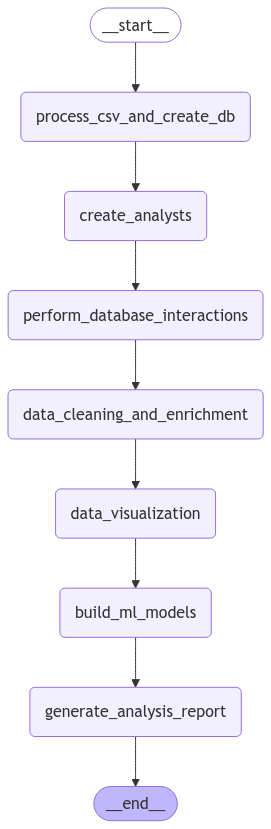

In [221]:
build_analysis_workflow()

In [222]:
def run_analysis(csv_file_path, analysis_goal, max_analysts=4, database_name=None, table_name=None):
    """Run the analysis workflow on a CSV file"""
    graph = build_analysis_workflow()

    # Initial state setup
    initial_state = {
        "csv_path": csv_file_path,  
        "analysis_goal": analysis_goal,
        "max_analysts": max_analysts,
        "database_name": database_name,
        "table_name": table_name
    }

    thread = {"configurable": {"thread_id": "1"}}

    print("Initial state before running graph:", initial_state)

    # Run graph and stream results
    results = graph.invoke(initial_state, thread)

    print("Final results:", results)
    return results

In [223]:
run_analysis("train.csv", "")

Initial state before running graph: {'csv_path': 'train.csv', 'analysis_goal': '', 'max_analysts': 4, 'database_name': None, 'table_name': None}
⚠️ Error parsing data_df: data_df is not a valid dictionary
Final results: {'csv_path': 'train.csv', 'analysis_goal': '', 'max_analysts': 4, 'database_name': 'analysis_1740614489', 'table_name': 'data_table', 'analysts': [Analyst(name='Data Wizard', affiliation='Data Management Department', role='Database Engineer', data_analysis_focus='Database Management', description='The Database Engineer will create and manage the database schema, ensuring efficient indexing, data retrieval, and overall schema integrity. They will optimize SQL queries for performance and ensure that the database is scalable to handle potential increases in data volume.', analysis_results={'database_summary': {'database_created': 'analysis_1740614489', 'tables_created': ['data_table', 'None'], 'interactions_count': 0}}), Analyst(name='Data Cleaner', affiliation='Data Engin

{'csv_path': 'train.csv',
 'analysis_goal': '',
 'max_analysts': 4,
 'database_name': 'analysis_1740614489',
 'table_name': 'data_table',
 'analysts': [Analyst(name='Data Wizard', affiliation='Data Management Department', role='Database Engineer', data_analysis_focus='Database Management', description='The Database Engineer will create and manage the database schema, ensuring efficient indexing, data retrieval, and overall schema integrity. They will optimize SQL queries for performance and ensure that the database is scalable to handle potential increases in data volume.', analysis_results={'database_summary': {'database_created': 'analysis_1740614489', 'tables_created': ['data_table', 'None'], 'interactions_count': 0}}),
  Analyst(name='Data Cleaner', affiliation='Data Engineering Team', role='Data Engineer', data_analysis_focus='Data ETL and Preprocessing', description="The Data Engineer will focus on extracting, transforming, and loading (ETL) the raw data. They will clean and prep

### Complex graph not working atm 

In [87]:
def human_feedback(state: GenerateAnalystsState):
    """Ask for human feedback and update state accordingly"""
    prompt = """
    Analyst Configuration Review
    ---------------------------
    
    The system has generated the following analysts:
    {}
    
    Would you like to:
    1. Continue with these analysts
    2. Modify the analysts and restart
    
    If modifying, please provide your suggestions:
    """.format(state.get('analysts', 'No analysts generated yet'))
    
    # Simulate user input (for testing purposes)
    user_choice = input(prompt)  # Replace this with actual user input mechanism
    user_suggestions = input("Provide your suggestions (if any): ") if user_choice == "2" else ""
    
    # Update the state with the feedback
    state["human_analyst_feedback"] = {
        "choice": user_choice,
        "suggestions": user_suggestions
    }
    
    return state

In [88]:
def should_continue_after_feedback(state: GenerateAnalystsState):
    """Determine next node after receiving human feedback"""
    # Check if feedback indicates we should restart
    human_analyst_feedback = state.get('human_analyst_feedback', {})
    choice = human_analyst_feedback.get('choice', '1')
    
    if choice == '2': 
        return "create_analysts"  # Restart the process
    
    return "perform_database_interactions"  # Continue to the next node

def should_loop_after_report(state: GenerateAnalystsState):
    """Determine if we should loop back for more feedback after the report"""
    report_feedback = state.get('report_feedback', {})
    needs_revision = report_feedback.get('needs_revision', False)
    
    if needs_revision:
        return "human_feedback"  # Loop back for feedback
    return END  # End the workflow

In [89]:
def should_loop_after_report(state: GenerateAnalystsState):
    """Determine if we should loop back for more feedback after the report"""
    report_feedback = state.get('report_feedback', {})
    needs_revision = report_feedback.get('needs_revision', False)
    
    if needs_revision:
        return "human_feedback"
    return END

# Build the workflow
def build_analysis_workflow():
    builder = StateGraph(GenerateAnalystsState)
    
    # Define nodes
    builder.add_node("process_csv_and_create_db", process_csv_and_create_db)
    builder.add_node("create_analysts", create_analysts)
    builder.add_node("human_feedback", human_feedback)
    builder.add_node("perform_database_interactions", perform_database_interactions)
    builder.add_node("data_cleaning_and_enrichment", data_cleaning_and_enrichment)
    builder.add_node("data_visualization", data_visualization)
    builder.add_node("build_ml_models", build_ml_models)
    builder.add_node("generate_analysis_report", generate_analysis_report)
    
    # Define workflow edges
    builder.add_edge(START, "process_csv_and_create_db")
    builder.add_edge("process_csv_and_create_db", "create_analysts")
    builder.add_edge("create_analysts", "human_feedback")
    
    # Add conditional edge after human_feedback to either continue or restart
    builder.add_conditional_edges(
        "human_feedback", 
        should_continue_after_feedback, 
        ["create_analysts", "perform_database_interactions"]
    )
    
    builder.add_edge("perform_database_interactions", "data_cleaning_and_enrichment")
    builder.add_edge("data_cleaning_and_enrichment", "data_visualization")
    builder.add_edge("data_visualization", "build_ml_models")
    builder.add_edge("build_ml_models", "generate_analysis_report")
    
    # Conditional loop for further human feedback after report generation
    builder.add_conditional_edges(
        "generate_analysis_report", 
        should_loop_after_report, 
        ["human_feedback", END]
    )
    
    # Compile the graph
    memory = MemorySaver()
    graph = builder.compile(
        interrupt_before=['human_feedback'], 
        checkpointer=memory
    )
    
    return graph

In [98]:
def build_analysis_workflow():
    builder = StateGraph(GenerateAnalystsState)
    
    # Define nodes
    builder.add_node("process_csv_and_create_db", process_csv_and_create_db)
    builder.add_node("create_analysts", create_analysts)
    builder.add_node("perform_database_interactions", perform_database_interactions)
    builder.add_node("data_cleaning_and_enrichment", data_cleaning_and_enrichment)
    builder.add_node("data_visualization", data_visualization)
    builder.add_node("build_ml_models", build_ml_models)
    builder.add_node("generate_analysis_report", generate_analysis_report)
    
    # Define workflow edges
    builder.add_edge(START, "process_csv_and_create_db")
    builder.add_edge("process_csv_and_create_db", "create_analysts")
    
    # Directly proceed to perform_database_interactions after create_analysts
    builder.add_edge("create_analysts", "perform_database_interactions")
    
    # Continue with the rest of the workflow
    builder.add_edge("perform_database_interactions", "data_cleaning_and_enrichment")
    builder.add_edge("data_cleaning_and_enrichment", "data_visualization")
    builder.add_edge("data_visualization", "build_ml_models")
    builder.add_edge("build_ml_models", "generate_analysis_report")
    
    # Conditional loop for further human feedback after report generation
    builder.add_conditional_edges(
        "generate_analysis_report", 
        ["human_feedback", END]  # Remove "human_feedback" if no longer needed
    )
    
    # Compile the graph
    memory = MemorySaver()
    graph = builder.compile(
        checkpointer=memory  # Remove interrupt_before since human_feedback is removed
    )
    
    return graph

In [104]:
def build_analysis_workflow():
    builder = StateGraph(GenerateAnalystsState)
    
    # Define nodes
    builder.add_node("process_csv_and_create_db", process_csv_and_create_db)
    builder.add_node("create_analysts", create_analysts)
    builder.add_node("perform_database_interactions", perform_database_interactions)
    builder.add_node("data_cleaning_and_enrichment", data_cleaning_and_enrichment)
    builder.add_node("data_visualization", data_visualization)
    builder.add_node("build_ml_models", build_ml_models)
    builder.add_node("generate_analysis_report", generate_analysis_report)
    
    # Define workflow edges
    builder.add_edge(START, "process_csv_and_create_db")
    builder.add_edge("process_csv_and_create_db", "create_analysts")
    
    # Directly proceed to perform_database_interactions after create_analysts
    builder.add_edge("create_analysts", "perform_database_interactions")
    
    # Continue with the rest of the workflow
    builder.add_edge("perform_database_interactions", "data_cleaning_and_enrichment")
    builder.add_edge("data_cleaning_and_enrichment", "data_visualization")
    builder.add_edge("data_visualization", "build_ml_models")
    builder.add_edge("build_ml_models", "generate_analysis_report")
    
    # Directly proceed to END after generate_analysis_report
    builder.add_edge("generate_analysis_report", END)
    
    # Compile the graph
    memory = MemorySaver()
    graph = builder.compile(
        checkpointer=memory
    )
    
    return graph

In [92]:
def handle_human_feedback(state, config, interrupt_data):
    """Handle human feedback interruptions"""
    print("\n" + "="*50)
    print("HUMAN FEEDBACK REQUIRED")
    print("="*50)
    
    # Display the prompt
    prompt = state.get('feedback_prompt', 'Please provide feedback:')
    print(prompt)
    
    # Get user input
    choice = input("Your choice (1/2): ")
    suggestions = ""
    if choice == "2":
        suggestions = input("Please provide your suggestions: ")
    
    # Check if we're after report generation
    needs_revision = False
    revision_comments = ""
    if getattr(state, "report_generated", False):
        needs_revision = input("Does the report need revision? (y/n): ").lower() == 'y'
        if needs_revision:
            revision_comments = input("Revision comments: ")
    
    # Update the state
    state.human_analyst_feedback = {
        "choice": choice,
        "suggestions": suggestions
    }
    
    if getattr(state, "report_generated", False):
        state.report_feedback = {
            "needs_revision": needs_revision,
            "revision_comments": revision_comments
        }
    
    # Print separation line
    print("="*50)
    
    # Return the updated state
    return state

In [ ]:
run_analysis("train.csv", "")

In [420]:
run_analysis("train.csv", "plot a visualization")

Initial state before running graph: {'csv_path': 'train.csv', 'analysis_goal': 'plot a visualization', 'max_analysts': 4, 'database_name': None, 'table_name': None}
⚠️ Error parsing data_df: data_df is not a valid dictionary
⚠️ LLM response is not valid JSON. Returning raw response.
Final results: {'csv_path': 'train.csv', 'analysis_goal': 'plot a visualization', 'max_analysts': 4, 'database_name': 'agent', 'table_name': 'data_table', 'analysts': "Based on the analysis goals and dataset provided, here are four AI analyst personas assigned to distinct themes, each with their relevant expertise:\n\n### Theme 1: Data Aggregation and Preparation\n\n**Analyst: Data Engineer – Samira Techwood**\n\n**Expertise:** \n- Samira specializes in data ingestion, transformation, and loading (ETL processes). She has experience in working with large datasets and cleaning data to ensure consistent formats and quality.\n\n**Approach:** \n- Samira would first connect to the data source, ensuring that any e

{'csv_path': 'train.csv',
 'analysis_goal': 'plot a visualization',
 'max_analysts': 4,
 'database_name': 'agent',
 'table_name': 'data_table',
 'analysts': "Based on the analysis goals and dataset provided, here are four AI analyst personas assigned to distinct themes, each with their relevant expertise:\n\n### Theme 1: Data Aggregation and Preparation\n\n**Analyst: Data Engineer – Samira Techwood**\n\n**Expertise:** \n- Samira specializes in data ingestion, transformation, and loading (ETL processes). She has experience in working with large datasets and cleaning data to ensure consistent formats and quality.\n\n**Approach:** \n- Samira would first connect to the data source, ensuring that any extracted data maintains integrity. Given that there is no valid data found currently, she will set a framework for data validation. She’ll create pipelines to handle the transformation needed for the data schema, such as converting values to appropriate data types and filtering out irrelevant 